In [44]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight

from sklearn.metrics import classification_report, confusion_matrix
import zipfile, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(tf.__version__)


2.10.1


In [45]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:", len(gpus))
else:
    print("No GPUs available.")

Available GPUs: 1


In [46]:
base_dir = 'chest'
train_dir = 'chest/train'
test_dir = 'chest/test'
val_dir = 'chest/val'
os.listdir(base_dir)

['test', 'train', 'val']

Preview of Training Images:


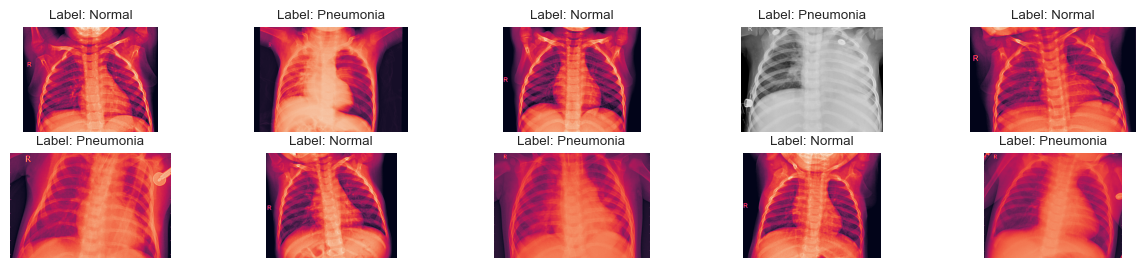

Preview of Validation Images:


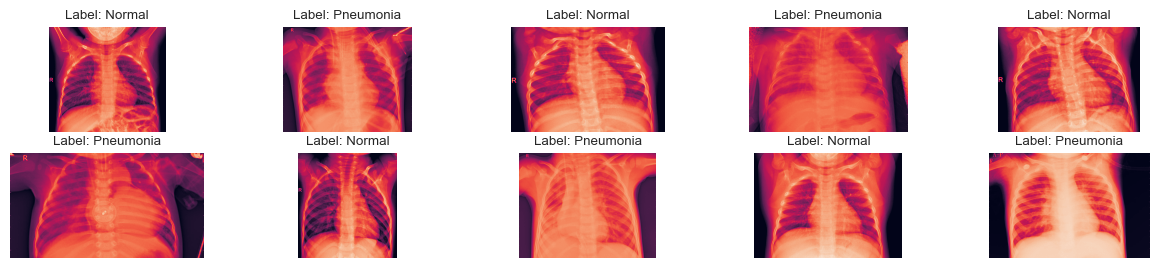

In [47]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Function to preview images directly from a directory
def preview_images_from_directory(directory, class_labels, num_images=5):
    class_names = os.listdir(directory)

    plt.figure(figsize=(15, 3))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpeg')]
        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        for i, image_file in enumerate(selected_images):
            plt.subplot(len(class_names), num_images, len(class_names) * i + class_names.index(class_name) + 1)
            img_path = os.path.join(class_path, image_file)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"Label: {class_labels[class_names.index(class_name)]}")
            plt.axis('off')

    plt.show()

# Define class labels for binary classification
class_labels_binary = ["Normal", "Pneumonia"]

# Preview images from the training directory
print("Preview of Training Images:")
preview_images_from_directory(train_dir, class_labels_binary)

# Preview images from the validation directory
print("Preview of Validation Images:")
preview_images_from_directory(val_dir, class_labels_binary)


In [48]:
img_width, img_height = 224, 224
batch_size = 128

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)



Found 4204 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.


Preview of Training Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


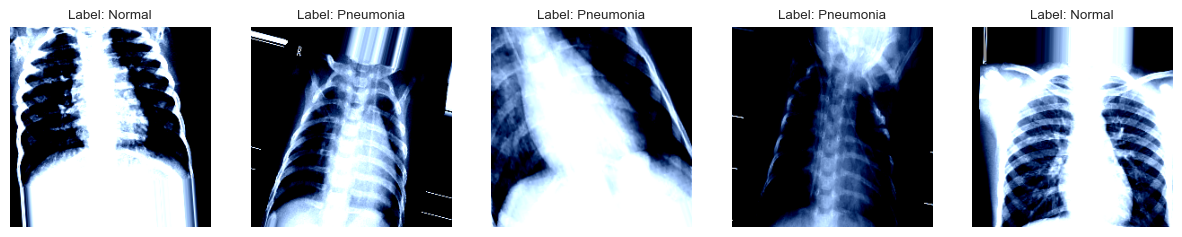

Preview of Validation Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


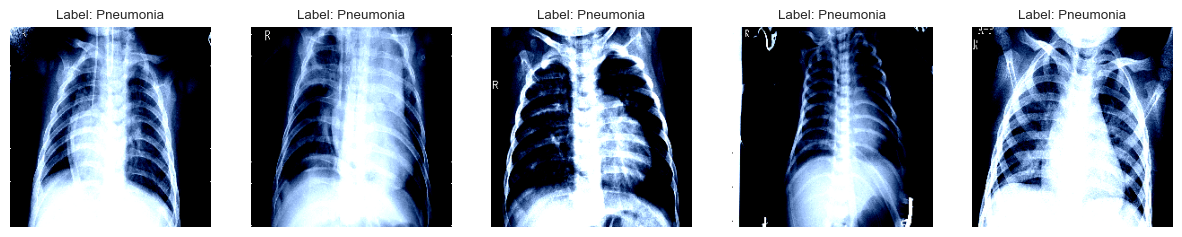

In [49]:
# Function to preview images from a data generator with class labels
def preview_images(generator, class_labels, num_images=5):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Map numeric labels to class names
    class_names = [class_labels[int(label)] for label in labels]

    # Display the images with labels
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[i]}")
        plt.axis('off')
    plt.show()

# Define class labels for binary classification
class_labels_binary = ["Normal", "Pneumonia"]

# Preview images from the training generator
print("Preview of Training Images:")
preview_images(train_generator, class_labels_binary)

# Preview images from the validation generator
print("Preview of Validation Images:")
preview_images(val_generator, class_labels_binary)


Number of samples in training set: 4204
Number of samples in validation set: 1052


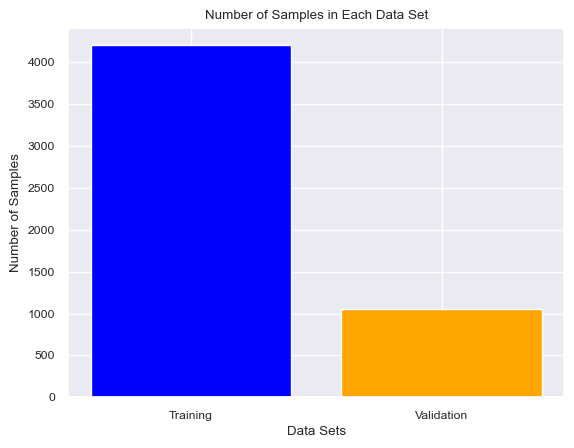

In [50]:
# Display the number of samples in each set
print("Number of samples in training set:", len(train_generator.classes))
print("Number of samples in validation set:", len(val_generator.classes))

# Visualize the number of samples in each set with a bar chart
sets = ['Training', 'Validation']
counts = [len(train_generator.classes), len(val_generator.classes)]

plt.bar(sets, counts, color=['blue', 'orange'])
plt.xlabel('Data Sets')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Data Set')
plt.show()


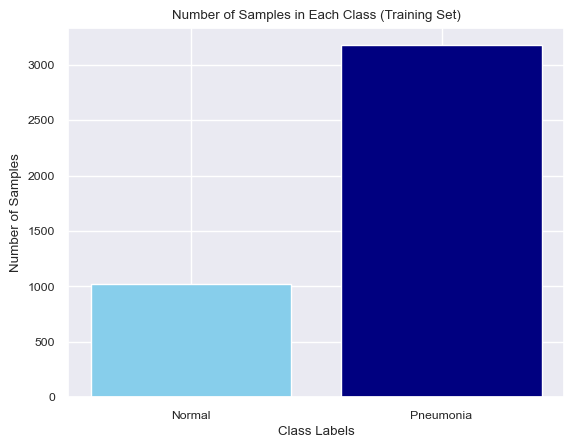

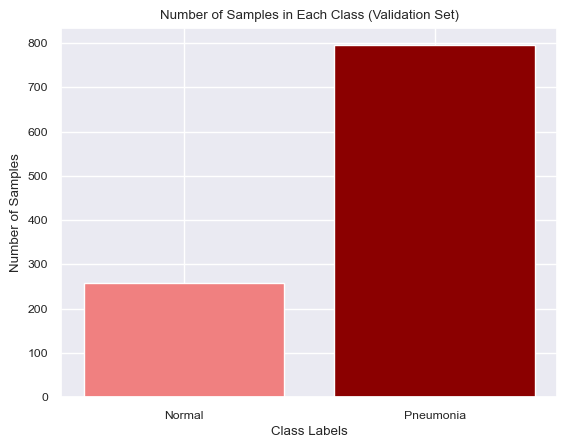

In [51]:
# Display the number of samples in each class within the training set
train_class_counts = np.bincount(train_generator.classes)
train_class_labels = ['Normal', 'Pneumonia']

plt.bar(train_class_labels, train_class_counts[:len(train_class_labels)], color=['skyblue', 'navy'])
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class (Training Set)')
plt.show()

# Display the number of samples in each class within the validation set
val_class_counts = np.bincount(val_generator.classes)
val_class_labels = ['Normal', 'Pneumonia']

plt.bar(val_class_labels, val_class_counts[:len(val_class_labels)], color=['lightcoral', 'darkred'])
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class (Validation Set)')
plt.show()

In [52]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 2.0487329434697856, 1: 0.6614222781623663}

In [53]:
densenet201 = DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in densenet201.layers:
    layer.trainable = False

x = densenet201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
pred = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=densenet201.input, outputs=pred)

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', save_best_only=True, mode='max', verbose=1)

In [55]:
epochs=50

hist = model.fit(train_generator,
                 epochs=epochs,
                 validation_data=val_generator,
                 # callbacks=[reduce_lr],
                 callbacks=[early_stopping, reduce_lr, model_checkpoint],
                 class_weight=class_weight_dict
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 3.2249 - binary_accuracy: 0.7935
Epoch 1: val_binary_accuracy improved from -inf to 0.83555, saving model to best_model.h5
33/33 [==============================] - 92s 2s/step - loss: 3.2249 - binary_accuracy: 0.7935 - val_loss: 2.0514 - val_binary_accuracy: 0.8356 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.6341 - binary_accuracy: 0.8711
Epoch 2: val_binary_accuracy improved from 0.83555 to 0.87738, saving model to best_model.h5
33/33 [==============================] - 77s 2s/step - loss: 1.6341 - binary_accuracy: 0.8711 - val_loss: 1.3944 - val_binary_accuracy: 0.8774 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.2429 - binary_accuracy: 0.9018
Epoch 3: val_binary_accuracy improved from 0.87738 to 0.89354, saving model to best_model.h5
33/33 [==============================] - 76s 2s/step - loss: 1.2429 - binary_accuracy: 0.9018 - val_loss: 1.1

In [56]:
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc}')

9/9 [==============================] - 9s 952ms/step - loss: 0.2971 - binary_accuracy: 0.9221
Test accuracy: 0.9220532178878784


In [57]:
hist_= pd.DataFrame(hist.history)
hist_

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,3.224909,0.793530,2.051356,0.835551,0.001000
1,1.634081,0.871075,1.394444,0.877376,0.001000
2,1.242862,0.901760,1.158241,0.893536,0.001000
3,1.088902,0.904853,1.071698,0.876426,0.001000
4,0.963436,0.910561,0.956413,0.885932,0.001000
5,0.871203,0.918411,0.917475,0.873574,0.001000
6,0.790616,0.925309,0.808201,0.893536,0.001000
7,0.720559,0.931970,0.756465,0.890684,0.001000
8,0.676813,0.926499,0.676779,0.913498,0.001000
9,0.627585,0.927688,0.674429,0.894487,0.001000


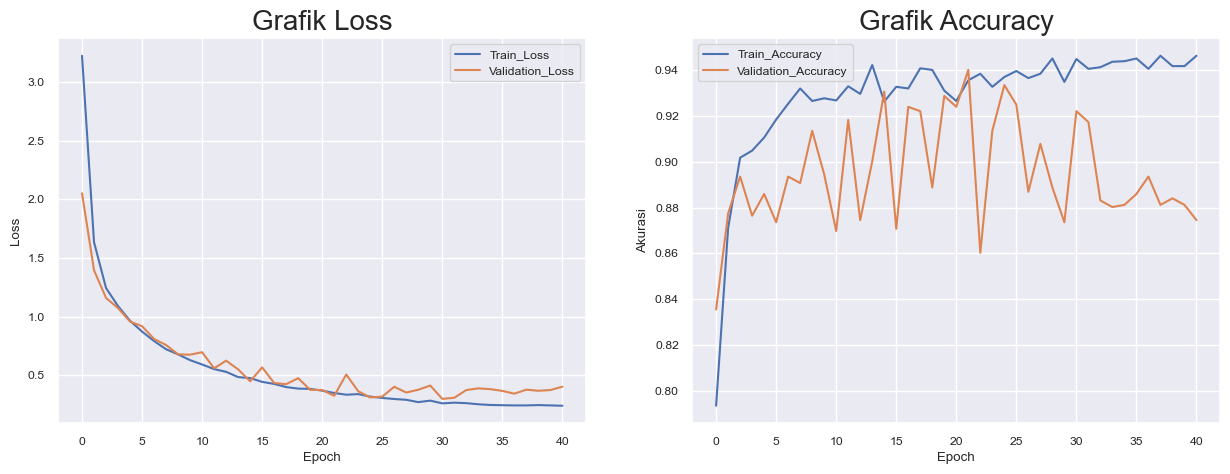

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Grafik Loss',fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['binary_accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_binary_accuracy'],label='Validation_Accuracy')
plt.title('Grafik Accuracy',fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

In [59]:
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 600 images belonging to 2 classes.


In [60]:
y_pred = model.predict(test_generator)

5/5 [==============================] - 10s 1s/step


In [61]:
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

In [62]:
classification_rep = classification_report(y_true, y_pred_binary, target_names=['Normal', 'Pneumonia'])
confusion_mat = confusion_matrix(y_true, y_pred_binary)

print("Classification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.99      0.95       300
   Pneumonia       0.99      0.91      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600


Confusion Matrix:
 [[297   3]
 [ 27 273]]


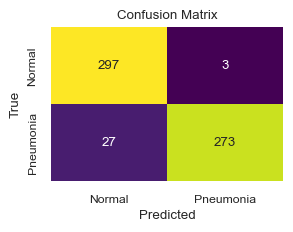

In [63]:
plt.figure(figsize=(3, 2))
sns.set(font_scale=0.8)
sns.heatmap(confusion_mat, annot=True, cmap='viridis', cbar=False, fmt='d', 
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [64]:
model.save('pneumonia_densenet201v2.h5')

1/1 [==============================] - 4s 4s/step
chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg
Image classified as Pneumonia
[0.9863094]


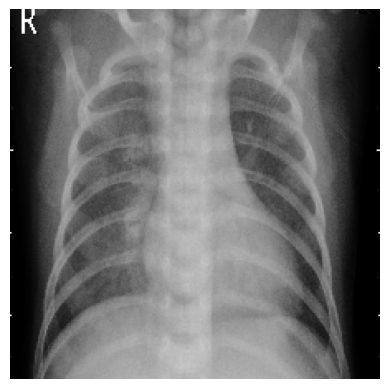

In [65]:
# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
img = image.load_img('chest/val/PNEUMONIA/person74_virus_135.jpeg', target_size=(224,224,3))

imgplot = plt.imshow(img)
plt.axis('off')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
images = np.vstack([x])

classes = model.predict(images)
print('chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg')
if classes[0] > 0.5:
  print('Image classified as Pneumonia')
else:
  print('Image classified as Normal')
print(classes[0])